<a href="https://colab.research.google.com/github/Ahntea/pytorch_from_scratch/blob/main/fcn_age_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.font_manager as fm
import os

!apt-get -qq -y install fonts-nanum > /dev/null
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
fm._rebuild()
# 단계 3: 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

# 마이너스 표시 문제
mpl.rcParams['axes.unicode_minus'] = False
	
# 한글 폰트 설정
path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'
font_name = fm.FontProperties(fname=path, size=18).get_name()
plt.rc('font', family=font_name)
fm._rebuild()

# filename = "/content/drive/MyDrive/thumbnail_list.txt"
train_filename = "/content/drive/MyDrive/training_list.txt"
valid_filename = "/content/drive/MyDrive/valid_list.txt"

import unicodedata

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !(ls drive/MyDrive/training >> training_list.txt)
# !(ls drive/MyDrive/valid >> valid_list.txt)

In [ ]:
# 한글 변환
train_list = []
with open(train_filename) as f:
    for line in f:
        train_list.append(unicodedata.normalize("NFC", line.strip()))

valid_list = []
with open(valid_filename) as f:
    for line in f:
        valid_list.append(unicodedata.normalize("NFC", line.strip()))

In [ ]:
# train dataframe 생성
pd_train = pd.DataFrame(train_list)
pd_train["image"]= pd_train[0].str.replace('_PMT.jpg', '.jpg')
pd_train.rename(columns = {0:"filename"}, inplace = True)

# valid dataframe 생성
pd_valid = pd.DataFrame(valid_list)
pd_valid["image"]= pd_valid[0].str.replace('_PMT.jpg', '.jpg')
pd_valid.rename(columns = {0:"filename"}, inplace = True)

In [ ]:
# image 생성날짜 dataframe 로드 및 merge
imt = pd.read_csv("/content/drive/MyDrive/csv_image_table_1015.csv")

merged = pd.merge(pd_train, imt, how="left", on = "image" )
merged['gen_date'] = pd.to_datetime(merged[['year','month','day']], format='%Y%m%d')
merged["birth_date"] = merged["image"].str.split('_', expand=True)[2]
merged["birth_date"] = merged["birth_date"].astype("datetime64[ns]")
merged["age"] = (merged["gen_date"] - merged["birth_date"]) / np.timedelta64(1, 'Y')
merged["age"].fillna(35, inplace=True)
merged["age"] = merged["age"].astype(int)
merged.loc[merged["age"]==119, "age"] = 19
merged["category"] = merged["image"].str.split('_', expand=True)[4]
d_ages = merged[['filename','age']].set_index('filename').T.to_dict('list')

In [ ]:
merged.to_csv('train.csv',
                  sep=',',na_rep='NaN',columns = ['image','filename', 'age'],index = False)

In [ ]:
# image 생성날짜 dataframe 로드 및 merge
imt = pd.read_csv("/content/drive/MyDrive/csv_image_table_1015.csv")

m_valid = pd.merge(pd_valid, imt, how="left", on = "image" )
m_valid['gen_date'] = pd.to_datetime(m_valid[['year','month','day']], format='%Y%m%d')
m_valid["birth_date"] = m_valid["image"].str.split('_', expand=True)[2]
m_valid["birth_date"] = m_valid["birth_date"].astype("datetime64[ns]")
m_valid["age"] = (m_valid["gen_date"] - m_valid["birth_date"]) / np.timedelta64(1, 'Y')
m_valid["age"].fillna(35, inplace=True)
m_valid["age"] = m_valid["age"].astype(int)
m_valid.loc[m_valid["age"]==119, "age"] = 19
m_valid["category"] = m_valid["image"].str.split('_', expand=True)[4]
valid_ages = m_valid[['filename','age']].set_index('filename').T.to_dict('list')
m_valid.to_csv('valid.csv',
                  sep=',',na_rep='NaN',columns = ['image','filename', 'age'],index = False)

In [ ]:
m_valid.head(5)

,filename,image,Unnamed: 0,folder_num,year,month,day,hour,min,sec,gen_date,birth_date,age,category
0,곡효애_F_1979-12-25_6393_보톡스_399796_PMT.jpg,곡효애_F_1979-12-25_6393_보톡스_399796.jpg,0.0,6393.0,2018.0,10.0,15.0,13.0,23.0,0.0,2018-10-15,1979-12-25,38,보톡스
1,곡효애_F_1979-12-25_6393_보톡스_399797_PMT.jpg,곡효애_F_1979-12-25_6393_보톡스_399797.jpg,1.0,6393.0,2018.0,10.0,15.0,13.0,23.0,5.0,2018-10-15,1979-12-25,38,보톡스
2,곡효애_F_1979-12-25_6393_보톡스_399798_PMT.jpg,곡효애_F_1979-12-25_6393_보톡스_399798.jpg,2.0,6393.0,2018.0,10.0,15.0,13.0,23.0,10.0,2018-10-15,1979-12-25,38,보톡스
3,곡효애_F_1979-12-25_6393_보톡스_399799_PMT.jpg,곡효애_F_1979-12-25_6393_보톡스_399799.jpg,3.0,6393.0,2018.0,10.0,15.0,13.0,23.0,15.0,2018-10-15,1979-12-25,38,보톡스
4,고현진_F_1980-09-27_23730_윤곽주사_456266_PMT.jpg,고현진_F_1980-09-27_23730_윤곽주사_456266.jpg,2.0,23730.0,2019.0,3.0,2.0,14.0,5.0,27.0,2019-03-02,1980-09-27,38,윤곽주사


In [ ]:
import torch
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class CustomDataset(torch.utils.data.Dataset): 
  def __init__(self, csv_file, root_dir, transform=None):
    self.csv_file = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    load_data = self.csv_file
    return len(load_data)
  
  def __getitem__(self, idx): 
    img_name = os.path.join(self.root_dir, self.csv_file.iloc[idx, 1])
    image = io.imread(img_name)
    label = self.csv_file.iloc[idx,2]

    # sample = {'image' : image, 'label' : label}
    sample = {'image' : image, 'label' : np.array(label)}
    if self.transform:
      sample = self.transform(sample)
    return sample
      

In [ ]:
train_ds = CustomDataset('train.csv', '/content/drive/MyDrive/training/')
valid_ds = CustomDataset('valid.csv', '/content/drive/MyDrive/valid/')

In [ ]:
print(train_ds[3]['image'].shape, valid_ds[3]['image'].shape)

(96, 100, 3) (96, 100, 3)


In [ ]:
# for image, age in dataset:
#   print(image.shape)

In [ ]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        # image, age =sample
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))
        
        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively

        return {'image' : img, 'label' : label}

In [ ]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample['image']
        label = sample['label']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        img = image.transpose((2, 0, 1))
        # return {'image' : torch.from_numpy(img), 'label' :torch.from_numpy(label)}
        return torch.from_numpy(img), torch.from_numpy(label)

In [ ]:
scale = Rescale((96,100))
composed = transforms.Compose([Rescale((96,100))])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = train_ds[65]
for i, tsfrm in enumerate([scale,composed]):
    transformed_sample = tsfrm(sample)
    print(transformed_sample['image'].shape)

(96, 100, 3)
(96, 100, 3)


<Figure size 432x288 with 0 Axes>

In [ ]:
# transformed_dataset = CustomDataset(csv_file='agedata.csv',root_dir='/content/drive/MyDrive/training/',
#                                     transform=transforms.Compose([Rescale((96,100)),ToTensor()]))
train_dataset = CustomDataset(csv_file='train.csv',root_dir='/content/drive/MyDrive/training/',  transform=transforms.Compose([
                                               Rescale((96,100)),
                                               ToTensor()
                                           ]))
valid_dataset = CustomDataset(csv_file='valid.csv',root_dir='/content/drive/MyDrive/valid/',  transform=transforms.Compose([
                                               Rescale((96,100)),
                                               ToTensor()
                                           ]))

In [ ]:
print(train_dataset)
# print(transformed_dataset[0]['label'])

In [ ]:
train_dl = DataLoader(train_dataset, batch_size=8,shuffle=True, num_workers=0)
valid_dl = DataLoader(valid_dataset, batch_size=16,shuffle=True, num_workers=0)

In [ ]:
i= 0

for x, y in train_dl:
  if i==3:
    break
  # print(x.shape,y.reshape(len(y),1).shape)
  # print(torch.flatten(x, start_dim=1).shape, y)
  print(x.shape, y.reshape(len(y),1).shape)
  i += 1

torch.Size([8, 3, 96, 100]) torch.Size([8, 1])
torch.Size([8, 3, 96, 100]) torch.Size([8, 1])
torch.Size([8, 3, 96, 100]) torch.Size([8, 1])


In [ ]:
import torch
from torch import nn
from torch import optim
class Age_Regression(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(28800, 7200)
        self.lin2 = nn.Linear(7200, 100)
        self.lin3 = nn.Linear(100, 1)

    def forward(self, xb):
        xb = torch.flatten(xb, start_dim=1)
        xb = self.lin1(xb)
        xb = self.lin2(xb)
        return self.lin3(xb)

In [ ]:
def get_model():
    model = Age_Regression()
    return model, optim.SGD(model.parameters(), lr=1e-5)

In [ ]:
model, opt = get_model()

In [ ]:
loss_func = nn.MSELoss()

In [ ]:
epochs = 50

In [ ]:
losses = []
for epoch in range(epochs):
  model.train()
  for train_x,train_y in train_dl:
    pred = model(train_x.float())
    loss = loss_func(pred, train_y.reshape(len(train_y),1).float())

    loss.backward()
    opt.step()
    opt.zero_grad()

  model.eval()
  with torch.no_grad():
    valid_loss = sum(loss_func(model(xb.float()), yb.reshape(len(yb),1)) for xb, yb in valid_dl)

  lossed = loss_func(model(train_x.float()),train_y.reshape(len(train_y),1))
  losses.append(lossed)
  print(epoch, lossed, valid_loss/len(valid_dl))

0 tensor(1644.2369, grad_fn=<MseLossBackward0>) tensor(544.2067)
1 tensor(250.4236, grad_fn=<MseLossBackward0>) tensor(123.8857)
2 tensor(57.4288, grad_fn=<MseLossBackward0>) tensor(167.5852)
3 tensor(102.1758, grad_fn=<MseLossBackward0>) tensor(183.5249)
4 tensor(161.4993, grad_fn=<MseLossBackward0>) tensor(182.0886)
5 tensor(58.1181, grad_fn=<MseLossBackward0>) tensor(182.9422)
6 tensor(67.1288, grad_fn=<MseLossBackward0>) tensor(252.8690)
7 tensor(28.1217, grad_fn=<MseLossBackward0>) tensor(241.9362)
8 tensor(69.5658, grad_fn=<MseLossBackward0>) tensor(224.2405)
9 tensor(116.7456, grad_fn=<MseLossBackward0>) tensor(172.3393)
10 tensor(254.0982, grad_fn=<MseLossBackward0>) tensor(177.6678)
11 tensor(166.4672, grad_fn=<MseLossBackward0>) tensor(211.4479)
12 tensor(134.5405, grad_fn=<MseLossBackward0>) tensor(187.1370)
13 tensor(14.8688, grad_fn=<MseLossBackward0>) tensor(176.2597)
14 tensor(66.9589, grad_fn=<MseLossBackward0>) tensor(163.7437)
15 tensor(58.3325, grad_fn=<MseLossBackwa

In [ ]:
torch.save(model.state_dict(),"fc_model.pth")

In [ ]:
sc = []
for lo in losses:
  sc.append(lo.item())

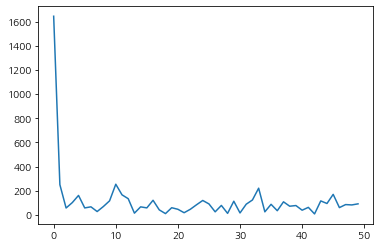

In [ ]:
plt.plot(sc)

In [ ]:
# train_features, train_labels = next(iter(dataloader))
# print(train_features, train_labels)

image label


In [ ]:
# train_features, train_labels = next(iter(dataloader))
# print(f"Feature batch shape: {train_features.size()}")
# print(f"Labels batch shape: {train_labels.size()}")
# img = train_features[0].squeeze()
# label = train_labels[1]
# plt.imshow(img, cmap="gray")
# plt.show()

In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.relu_stack = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.Conv2d(32, 64, 5, padding=0),
            nn.MaxPool2d(2, 2),
            nn.Linear(9600, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


In [ ]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=9600, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [ ]:
X = torch.rand(3, 96, 100, device=device)
logits = model(X)
pred_probab = nn.MSELoss()
y_pred = logits
print(f"Predicted class: {y_pred}")

Predicted class: tensor([[0.0515],
        [0.0711],
        [0.0528]], grad_fn=<AddmmBackward0>)


In [ ]:
# 모델 선언
import torch
from torch.utils.data import TensorDataset, DataLoader
from skimage import io, transform
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(3, 32, 3, padding=1),
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.MaxPool2d(2),
    nn.Linear(153600, 7200),
    # nn.Linear(38400, 7200),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(7200, 800), 
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(800, 16), 
    nn.ReLU(),
    nn.Linear(16, 1) 
)

print(list(model.parameters()))
import math

# weights = torch.randn(28800, 1) / math.sqrt(28800)
# weights.requires_grad_()
# bias = torch.zeros(1, requires_grad=True)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5) 
loss_fn = nn.MSELoss()
losses = []

Using cpu device


NameError: ignored

In [ ]:
epochs = 500
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)
fit(epochs, model, loss_fn, optimizer, dataloader, dataloader)


RuntimeError: ignored

In [ ]:

for epoch in range(nb_epochs+1):

    # H(x) 계산
    prediction = model(x_train)
    # model(x_train)은 model.forward(x_train)와 동일함.
    # print(prediction.shape, y_train.shape)
    # cost 계산
    loss = loss_fn(prediction, y_train.reshape(20,1)) # <== 파이토치에서 제공하는 평균 제곱 오차 함수

    # cost로 H(x) 개선하는 부분
    # gradient를 0으로 초기화
    # optimizer.zero_grad()
    # 비용 함수를 미분하여 gradient 계산
    loss.backward()
    # W와 b를 업데이트
    optimizer.step()

    if epoch % 100 == 0:
    # 100번마다 로그 출력
      print('Epoch {:4d}/{} Cost: {:.6f}'.format(
          epoch, nb_epochs, loss.item()
      ))
    
    losses.append(loss.item())
print(y_valid.shape, x_valid.shape)

torch.Size([86]) torch.Size([153, 28800])


In [ ]:
# 모델 선언
import torch
from torch.utils.data import TensorDataset, DataLoader
from skimage import io, transform
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
# x_train, y_train, x_valid, y_valid = map(
#     torch.tensor, (x_train/255, y_train, x_valid/255, y_valid)
# )
dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

# print(x_train.shape)
# n, c = x_train.shape
# print(x_train, y_train)
# print(x_train.shape)
# print(y_train.min(), y_train.max())

Using cuda device


In [ ]:
model = nn.Sequential(
    # nn.Conv2d(3, 32, 3, padding=1),
    # nn.Conv2d(32, 64, kernel_size=3, padding=1),
    # nn.MaxPool2d(2),
    # nn.Linear(153600, 7200),
    nn.Linear(28800, 7200),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(7200, 800), 
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(800, 16), 
    nn.ReLU(),
    nn.Linear(16, 1) 
)
print(list(model.parameters()))
import math

# weights = torch.randn(28800, 1) / math.sqrt(28800)
# weights.requires_grad_()
# bias = torch.zeros(1, requires_grad=True)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5) 
loss_fn = nn.MSELoss()
losses = []